### 1. Random Forest

Create the probability .csv file

In [29]:
import pandas as pd
import CONSTANT

df = pd.read_csv(CONSTANT.PATH_TO_TRAIN_CSV)

vote_cols = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]

# Normalize the votes to get probabilities
df["total_votes"] = df[vote_cols].sum(axis=1)
for col in vote_cols:
    df[col + "_prob"] = df[col] / df["total_votes"]

# Keep only needed columns
final_df = df[["eeg_id", "spectrogram_id", "expert_consensus"] + [col + "_prob" for col in vote_cols]]

# Drop duplicate eeg_ids — keep the first
final_df = final_df.drop_duplicates(subset="eeg_id", keep="first")

# Save to new CSV
final_df.to_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/random_forest_saved_data/eeg_vote_probs.csv", index=False)

Random Forest Model

In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
# Feature extraction from each EEG .parquet file
def extract_features_from_parquet(parquet_path):
    df = pd.read_parquet(parquet_path, columns=["Fp1", "O1", "O2", "Fp2"])

    features = {}
    for col in ["Fp1", "O1", "O2", "Fp2"]:
        features[f"{col}_mean"] = df[col].mean()
        features[f"{col}_std"] = df[col].std()
        features[f"{col}_min"] = df[col].min()
        features[f"{col}_max"] = df[col].max()
    
    return features

In [6]:
# Load the CSV
meta_df = pd.read_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/random_forest_saved_data/eeg_vote_probs.csv")

# Map expert consensus to integer labels
label_map = {label: i for i, label in enumerate(meta_df['expert_consensus'].unique())}
meta_df['label'] = meta_df['expert_consensus'].map(label_map)

In [7]:
# Loop through all EEGs and build dataset
data = []
labels = []

for _, row in meta_df.iterrows():
    eeg_id = row["eeg_id"]
    parquet_file = CONSTANT.PATH_TO_FILES_TRAIN_EEG+f"/{eeg_id}.parquet"
    
    if os.path.exists(parquet_file):
        features = extract_features_from_parquet(parquet_file)
        data.append(features)
        labels.append(row["label"])
    else:
        print(f"File not found: {parquet_file}")

In [8]:
features_df = pd.DataFrame(data)
labels = np.array(labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.3, random_state=42)

In [10]:
# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

              precision    recall  f1-score   support

     Seizure       0.49      0.38      0.43       801
         GPD       0.64      0.44      0.52       511
        LRDA       0.60      0.09      0.15       282
       Other       0.55      0.86      0.67      2222
        GRDA       0.49      0.16      0.24       538
         LPD       0.69      0.40      0.51       773

    accuracy                           0.56      5127
   macro avg       0.57      0.39      0.42      5127
weighted avg       0.56      0.56      0.52      5127



### 2. Multiclass SVM

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()

In [13]:
meta_df = pd.read_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/random_forest_saved_data/eeg_vote_probs.csv")
meta_df['label'] = le.fit_transform(meta_df['expert_consensus'])

In [15]:
PARQUET_DIR = CONSTANT.PATH_TO_FILES_TRAIN_EEG

In [18]:
# Feature extraction function
def extract_features_from_parquet(parquet_path):
    df = pd.read_parquet(parquet_path, columns=["Fp1", "O1", "O2", "Fp2"])
    features = {}
    for col in ["Fp1", "O1", "O2", "Fp2"]:
        features[f"{col}_mean"] = df[col].mean()
        features[f"{col}_std"] = df[col].std()
        features[f"{col}_min"] = df[col].min()
        features[f"{col}_max"] = df[col].max()
    return features

# Build feature dataset
data = []
labels = []

In [19]:
for _, row in meta_df.iterrows():
    eeg_id = row["eeg_id"]
    parquet_path = os.path.join(PARQUET_DIR, f"{eeg_id}.parquet")
    
    if os.path.exists(parquet_path):
        features = extract_features_from_parquet(parquet_path)
        data.append(features)
        labels.append(row["label"])
    else:
        print(f"Missing file: {parquet_path}")


In [20]:
# Convert to DataFrame
X = pd.DataFrame(data)
y = np.array(labels)

In [21]:
# Normalize features (important for SVM!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [ ]:
# Train Multiclass SVM
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True, random_state=42)  # RBF kernel for non-linear boundaries
clf.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [24]:
# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

         GPD       0.00      0.00      0.00       536
        GRDA       0.12      0.00      0.00       548
         LPD       0.00      0.00      0.00       773
        LRDA       0.00      0.00      0.00       275
       Other       0.42      0.98      0.59      2159
     Seizure       0.47      0.06      0.11       836

    accuracy                           0.42      5127
   macro avg       0.17      0.17      0.12      5127
weighted avg       0.27      0.42      0.27      5127



/Users/Patron/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Patron/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Patron/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

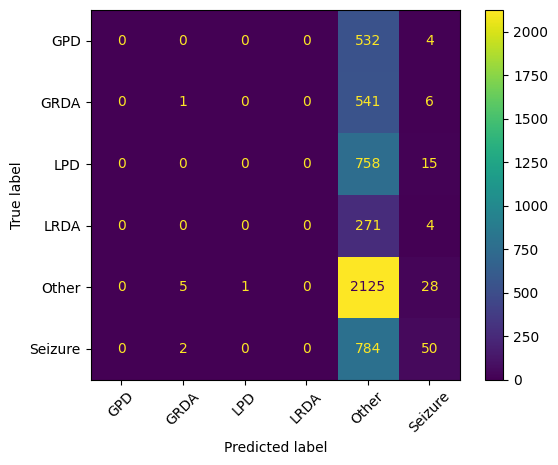

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap='viridis')
plt.show()


SVM Doesn't Handle Imbalance

In [26]:
# Train Multiclass SVM
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced') # added balanced
clf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [27]:
# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

         GPD       0.25      0.05      0.08       536
        GRDA       0.11      0.02      0.04       548
         LPD       0.17      0.83      0.29       773
        LRDA       0.14      0.01      0.01       275
       Other       0.76      0.12      0.21      2159
     Seizure       0.35      0.34      0.34       836

    accuracy                           0.24      5127
   macro avg       0.30      0.23      0.16      5127
weighted avg       0.45      0.24      0.20      5127



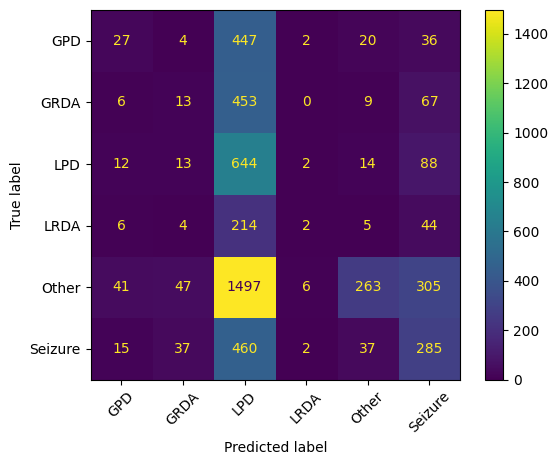

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap='viridis')
plt.show()
